INSTALLING REQUIRED ARCHITECTURE (PYTORCH,DETECTRON2,ETC)   

NOTE: WORKS ONLY ON GOOGLE COLAB

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.5 (from versions: 1.7.1, 1.7.1+cu101, 1.8.0, 1.8.0+cu101, 1.8.1, 1.8.1+cu101, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44090 sha256=89c5319f6ef7bdc255b886ff0c29e595c2e9deb9a220d2a1685d65ab2895da02
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
  

In [2]:

!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gxjmjwlg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gxjmjwlg
  Resolved https://github.com/facebookresearch/detectron2.git to commit 830d7967966b92bb357c06c52edf0d39a3e2d89d
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 15.3 MB/s eta 0:00:00
     

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
import os 

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

In [4]:
from detectron2.data.datasets import register_coco_instances


DECLARING REQUIRED PATHS

In [5]:
from google.colab import drive
#drive.mount("/content/drive")
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
training_images_path="/content/drive/MyDrive/seg.v5i.coco-segmentation/train"
testing_images_path="/content/drive/MyDrive/seg.v5i.coco-segmentation/valid"
training_json="/content/drive/MyDrive/seg.v5i.coco-segmentation/train/_annotations.coco.json"
testing_json="/content/drive/MyDrive/seg.v5i.coco-segmentation/valid/_annotations.coco.json"
eval_images_path="/content/drive/MyDrive/seg.v5i.coco-segmentation/test"
eval_json="/content/drive/MyDrive/seg.v5i.coco-segmentation/test/_annotations.coco.json"

TRAINING AND TESTING DATA ANALYSIS

In [7]:
train_coco=COCO(training_json)

loading annotations into memory...
Done (t=19.76s)
creating index...
index created!


In [8]:
category_ids = train_coco.loadCats(train_coco.getCatIds())

category_names = [_["name"] for _ in category_ids]

pprint(", ".join(category_names))

category_ids


('food, aloo_methi, aloo_tikki, bandar_laddu, besan_cheela, biryani, '
 'butter_chicken, butter_naan, chaat, chapati, chole, dal, dal_makhani, dosa, '
 'dum_aloo, gajar_ka_halwa, gulab_jamun, idli, indian_bread, kulfi, '
 'palak_paneer, paneer, pani_puri, plain_rice, poha, poori, rajma, rasgulla, '
 'sambar, samosa, sheer_korma, upma, uttapam, vada')


[{'id': 0, 'name': 'food', 'supercategory': 'none'},
 {'id': 1, 'name': 'aloo_methi', 'supercategory': 'food'},
 {'id': 2, 'name': 'aloo_tikki', 'supercategory': 'food'},
 {'id': 3, 'name': 'bandar_laddu', 'supercategory': 'food'},
 {'id': 4, 'name': 'besan_cheela', 'supercategory': 'food'},
 {'id': 5, 'name': 'biryani', 'supercategory': 'food'},
 {'id': 6, 'name': 'butter_chicken', 'supercategory': 'food'},
 {'id': 7, 'name': 'butter_naan', 'supercategory': 'food'},
 {'id': 8, 'name': 'chaat', 'supercategory': 'food'},
 {'id': 9, 'name': 'chapati', 'supercategory': 'food'},
 {'id': 10, 'name': 'chole', 'supercategory': 'food'},
 {'id': 11, 'name': 'dal', 'supercategory': 'food'},
 {'id': 12, 'name': 'dal_makhani', 'supercategory': 'food'},
 {'id': 13, 'name': 'dosa', 'supercategory': 'food'},
 {'id': 14, 'name': 'dum_aloo', 'supercategory': 'food'},
 {'id': 15, 'name': 'gajar_ka_halwa', 'supercategory': 'food'},
 {'id': 16, 'name': 'gulab_jamun', 'supercategory': 'food'},
 {'id': 17, 

In [9]:
no_images_per_category = {}

for n, i in enumerate(train_coco.getCatIds()):
  imgIds = train_coco.getImgIds(catIds=i)
  label = category_names[n]
  no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))

no_images_per_category


{'food': 0,
 'aloo_methi': 53,
 'aloo_tikki': 60,
 'bandar_laddu': 27,
 'besan_cheela': 280,
 'biryani': 143,
 'butter_chicken': 47,
 'butter_naan': 305,
 'chaat': 76,
 'chapati': 7,
 'chole': 149,
 'dal': 168,
 'dal_makhani': 75,
 'dosa': 291,
 'dum_aloo': 44,
 'gajar_ka_halwa': 41,
 'gulab_jamun': 96,
 'idli': 48,
 'indian_bread': 301,
 'kulfi': 162,
 'palak_paneer': 394,
 'paneer': 30,
 'pani_puri': 1,
 'plain_rice': 321,
 'poha': 316,
 'poori': 164,
 'rajma': 117,
 'rasgulla': 131,
 'sambar': 232,
 'samosa': 194,
 'sheer_korma': 42,
 'upma': 68,
 'uttapam': 205,
 'vada': 18}

LOADING DATASET

In [10]:
register_coco_instances("training",{},training_json,training_images_path)
register_coco_instances("testing",{},testing_json,testing_images_path)
register_coco_instances("evaluation",{},eval_json,eval_images_path)

MODEL CONFIGURATION AND TRAINING THE MODEL

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("training",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS="/content/drive/MyDrive/output-2/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 34



In [12]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/12 00:30:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/12 00:30:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/12 00:30:59 d2.utils.events]:  eta: 0:47:44  iter: 19  total_loss: 4.719  loss_cls: 3.865  loss_box_reg: 0.1629  loss_mask: 0.6939  loss_rpn_cls: 0.0006049  loss_rpn_loc: 0.005637    time: 0.5930  last_time: 0.6036  data_time: 0.2501  last_data_time: 0.2477   lr: 4.9953e-06  max_mem: 1863M
[03/12 00:31:11 d2.utils.events]:  eta: 0:46:43  iter: 39  total_loss: 2.841  loss_cls: 1.86  loss_box_reg: 0.2081  loss_mask: 0.685  loss_rpn_cls: 0.00084  loss_rpn_loc: 0.005932    time: 0.5768  last_time: 0.5460  data_time: 0.1811  last_data_time: 0.1793   lr: 9.9902e-06  max_mem: 1925M
[03/12 00:31:22 d2.utils.events]:  eta: 0:47:11  iter: 59  total_loss: 1.495  loss_cls: 0.5457  loss_box_reg: 0.3153  loss_mask: 0.6683  loss_rpn_cls: 0.0007469  loss_rpn_loc: 0.005344    time: 0.5737  last_time: 0.4628  data_time: 0.1649  last_data_time: 0.0738   lr: 1.4985e-05  max_mem: 2133M
[03/12 00:31:33 d2.utils.events]:  eta: 0:46:20  iter: 79  total_loss: 1.223  loss_cls: 0.362  loss_box_reg: 0.2367  l

In [13]:
microcontroller_metadata = MetadataCatalog.get("training")

PREDICTION

[03/12 01:10:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


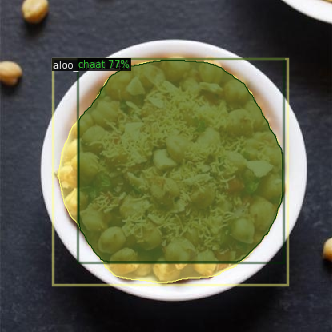

In [14]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS="/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("testing", )

predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/drive/MyDrive/seg.v5i.coco-segmentation/test/023e5732-chaattest_26_jpg.rf.65a3226eb241c373d5f71387a77a12c7.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
cv2_imshow(v.get_image()[:, :, ::-1])



MODEL EVALUATION

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("evaluation", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "evaluation")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)


WARNING [03/12 01:10:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/12 01:10:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/12 01:10:56 d2.data.datasets.coco]: Loaded 505 images in COCO format from /content/drive/MyDrive/seg.v5i.coco-segmentation/test/_annotations.coco.json
[03/12 01:10:56 d2.data.build]: Distribution of instances among all 34 categories:
|   category    | #instances   |   category   | #instances   |   category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:------------:|:-------------|
|     food      | 0            |  aloo_methi  | 4            |  aloo_tikki  | 30           |
| bandar_laddu  | 34           | besan_cheela | 21           |   biryani    | 22           |
| butter_chic.. | 10           | butter_naan  | 59           |    chaat     | 13  

OrderedDict([('bbox',
              {'AP': 39.98626513208384,
               'AP50': 54.7154243033383,
               'AP75': 46.770426258260045,
               'APs': 0.0,
               'APm': 23.537704027849955,
               'APl': 41.42179121337262,
               'AP-food': nan,
               'AP-aloo_methi': 22.937293729372936,
               'AP-aloo_tikki': 57.73779380102068,
               'AP-bandar_laddu': 47.131932221821124,
               'AP-besan_cheela': 55.685950153043926,
               'AP-biryani': 53.128812129333234,
               'AP-butter_chicken': 20.198019801980198,
               'AP-butter_naan': 52.947466217778114,
               'AP-chaat': 24.684992506694833,
               'AP-chapati': nan,
               'AP-chole': 33.5228932395502,
               'AP-dal': 34.90128894399235,
               'AP-dal_makhani': 45.26952695269528,
               'AP-dosa': 43.60851155196085,
               'AP-dum_aloo': 18.953645364536452,
               'AP-gajar_ka

GENERATING JSON FILE FROM PREDICTED IMAGE

[03/12 01:13:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


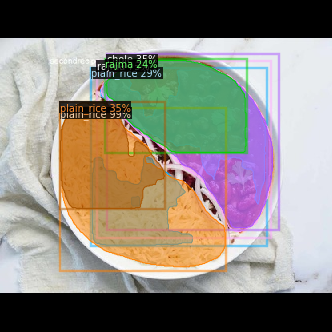

In [16]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS="/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("testing", )

predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/sample_data/rajma-chawal (1)-2.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
cv2_imshow(v.get_image()[:, :, ::-1])



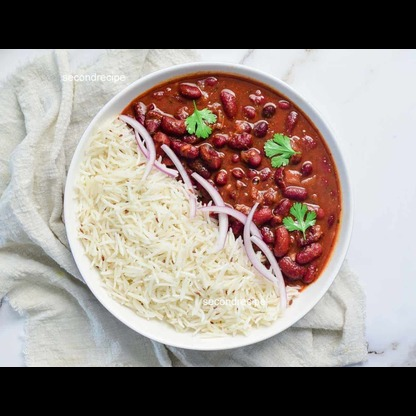

In [17]:
img=cv2.imread("/content/sample_data/rajma-chawal (1)-2.jpeg")
cv2_imshow(img)


In [18]:
def getList(dict):
    return dict.keys()
dict = outputs
print(getList(dict))
a=outputs["instances"]
b=a.get_fields()
scores=b['scores'].cpu().numpy()
rois=b['pred_boxes'].tensor.cpu().numpy()
pred_class=b['pred_classes'].cpu().numpy()
pred_masks=b['pred_masks'].cpu().numpy()


dict_keys(['instances'])


In [19]:
min_conf=0.60

(6, 416, 416)
confidence:  99.40656423568726     Class:  plain_rice
confidence:  75.36023259162903     Class:  rajma


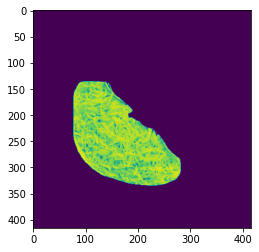

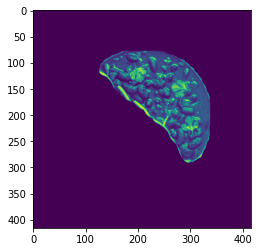

In [20]:
import tensorflow as tf
from skimage import io
masking=pred_masks
image_list=[]
image_names=[]

masking=masking.astype(int)
print(masking.shape)
for i in range(masking.shape[0]):
  if scores[i] > min_conf and category_names[pred_class[i]]!="Background":
    temp= io.imread('/content/sample_data/rajma-chawal (1)-2.jpeg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * masking[i,:,:]
    plt.figure(figsize=(4,4))
    
    
    temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    globals()[f"temp_{i}"] = temp
    image_list.append(i)
    b=cv2.countNonZero(temp)
    print("confidence: ",100*scores[i],"   ","Class: ",category_names[pred_class[i]])
    image_names.append(category_names[pred_class[i]])
    plt.imshow(temp)

In [23]:
!pip install imantics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16033 sha256=805382e512f5bd3a8457540e65c054475a493119ec6edee8de63284003e31a1a
  Stored in directory: /root/.cache/pip/wheels/45/65/ec/8f8f231fa40bc5d47798df399f65aea84d2e3a0ea296f81506
Successfully built imantics


In [21]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [22]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [24]:
import numpy as np
from imantics import Polygons, Mask
for i in image_list:
  temp=globals()[f"temp_{i}"]
  globals()[f"polygons_points_{i}"] = Mask(temp).polygons()
  globals()[f"polygons_cords_{i}"]=globals()[f"polygons_points_{i}"].points[0]




In [25]:
print(image_names)
print(image_list)

['plain_rice', 'rajma']
[0, 1]


In [26]:
plate_cords=[[38.054054054054056,136.64864864864865],

[18.16216216216216,251.64864864864865],

[65.72972972972974,379.6756756756757],



[510.2702702702703,252.54054054054055]
]

In [27]:
for i in plate_cords:
  i[0]=int(i[0])
  i[1]=int(i[1])
print(plate_cords)

[[38, 136], [18, 251], [65, 379], [510, 252]]


In [28]:
for i in image_list:
  globals()[f"polygons_cords_{i}"]=globals()[f"polygons_cords_{i}"].tolist()


In [29]:
plate ={
      "label":"plate",
      "line_color" : "null",
      "fill_color": "null",
      "points" : plate_cords,
     "shape_type" : "polygon"
    
    
}

In [30]:
shapes=[]
j=0
for i in image_list:
  
  a={
      "label":str(image_names[j]),
      "line_color" : "null",
      "fill_color": "null",
      "points" : globals()[f"polygons_cords_{i}"],
     "shape_type" : "polygon"
     
       
  }
  shapes.append(a)
  j=j+1
shapes.append(plate)


In [31]:
import json
data={
    "version": "3.5.0",
    "flags": {},
    "shapes" : shapes,
    "lineColor": [
    0,
    255,
    0,
    128
  ],
  "fillColor": [
    255,
    0,
    0,
    128
  ]

      }
json_object = json.dumps(data, indent = 4)
with open("data.json", "w") as outfile:
    outfile.write(json_object)


VOLUME DETECTION 

In [ ]:
cd "/content/drive/MyDrive/Food-Volume-Estimation-master/Volume Estimation"

/content/drive/MyDrive/Food-Volume-Estimation-master/Volume Estimation


In [ ]:
!python demo.py --img "/content/sample_data/rajma-chawal (1) (1).jpeg"  --json "/content/drive/MyDrive/Food-Volume-Estimation-master/Volume Estimation/data.json" --output "/content/drive/MyDrive/Food-Volume-Estimation/Volume Estimation/output"


<IPython.core.display.HTML object>
Traceback (most recent call last):
  File "/content/drive/MyDrive/Food-Volume-Estimation-master/Volume Estimation/demo.py", line 12, in <module>
    src = list(files.upload().values())[0]
  File "/usr/local/lib/python3.9/dist-packages/google/colab/files.py", line 69, in upload
    uploaded_files = _upload_files(multiple=True)
  File "/usr/local/lib/python3.9/dist-packages/google/colab/files.py", line 153, in _upload_files
    result = _output.eval_js(
  File "/usr/local/lib/python3.9/dist-packages/google/colab/output/_js.py", line 36, in eval_js
    kernel = _ipython.get_kernel()
  File "/usr/local/lib/python3.9/dist-packages/google/colab/_ipython.py", line 24, in get_kernel
    return get_ipython().kernel
AttributeError: 'NoneType' object has no attribute 'kernel'


In [54]:
total_volume = []
total_calorie = []
total_carbs = []
total_fats = []
total_protien = []

food_dic = {'aloo_methi': [100, 150, 12, 3, 10], 'aloo_tikki': [100, 157, 24.3, 3.6, 5],
            'bandar_laddu': [100, 390, 41.04, 5.63, 23.64],
            'besan_cheela': [100, 269, 36.61, 13.09, 8.07], 'biryani': [100, 139, 19.23, 6.36, 3.93],
            'butter_chicken': [100, 202, 4.32, 13.87, 14.52],
            'butter_naan': [100, 90, 44, 7, 1], 'chaat': [100, 189, 24.96, 4.8, 7.98],
            'chapati': [100, 170, 32.5, 5.84, 1.55],
            'chole': [100, 131, 13.3, 6, 6], 'dal': [100, 101, 13.36, 5.28, 3.23],
            'dal_makhani': [100, 181, 20.49, 6.78, 8.77],
            'dosa': [100, 212, 20.49, 6.78, 8.77], 'dum_aloo': [100, 131, 19.74, 3.19, 5.56],
            'gajar_ka_halwa': [100, 175, 30.48, 4.07, 5],
            'gulab_jamun': [100, 323, 39.26, 7.15, 15.75], 'idli': [100, 135, 26.31, 6.36, 0.62],
            'indian_bread': [100, 130, 19, 5, 3.5],
            'kulfi': [100, 227, 26.28, 4, 12.59], 'palak_paneer': [100, 169, 6.07, 7.89, 13.18],
            'paneer': [100, 293, 2.97, 14.01, 25.13],
            'pani_puri': [100, 307, 57.76, 6.09, 12.82], 'plain_rice': [100, 129, 89, 9, 2],
            'poha': [100, 110, 18.8, 2.34, 2.87],
            'poori': [100, 296, 46.73, 7.54, 9.43], 'rajma': [100, 165, 19.77, 7.04, 7.08],
            'rasgulla': [100, 213, 48.24, 3.62, 1.11],
            'sambar': [100, 513, 10.2, 2.8, 0.27], 'samosa': [100, 308, 32.21, 4.67, 17.86],
            'sheer_korma': [100, 208, 36.65, 4.2, 5.85],
            'upma': [100, 209, 38.06, 6.76, 3.15], 'uttapam': [100, 214, 30, 3.79, 8.76],
            'vada': [100, 282, 40.97, 10.59, 8.64]}
for i in range(len(image_names)):
    volume = float(input('Enter weight in grams for '+str(image_names[i])+':'))
    total_volume.append(volume)
print(total_volume)

for item in image_names:
    if item in food_dic:
        for i in range(len(total_volume)-1):
            calorie = (total_volume[i] / food_dic[item][0]) * food_dic[item][1]
            total_calorie.append(calorie)
            carbs = (total_volume[i] / food_dic[item][0]) * food_dic[item][2]
            total_carbs.append(carbs)
            fat = (total_volume[i] / food_dic[item][0]) * food_dic[item][3]
            total_fats.append(fat)
            protien = (total_volume[i] / food_dic[item][0]) * food_dic[item][4]
            total_protien.append(protien)
print(total_calorie)
print(total_carbs)
print(total_fats)
print(total_protien)
nutrients = []
meal_calories = sum(total_calorie)
meal_carbs = sum(total_carbs)
nutrients.append(meal_carbs)
meal_fats = sum(total_fats)
nutrients.append(meal_fats)
meal_protiens = sum(total_protien)
nutrients.append(meal_protiens)

Enter weight in grams for plain_rice:50
Enter weight in grams for rajma:50
[50.0, 50.0]
[64.5, 82.5]
[44.5, 9.885]
[4.5, 3.52]
[1.0, 3.54]


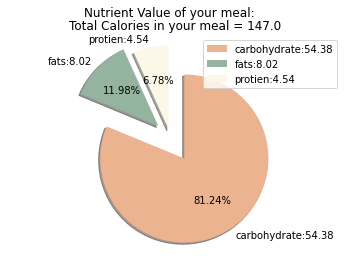

In [51]:
import matplotlib.pyplot as plt

myexplode = [0.3,0.2,0.1]
pie = plt.pie(nutrients,
              startangle=90,
              counterclock=False,
              autopct=lambda p: '{:.2f}%'.format(p),
              labels=["carbohydrate:"+str(round(meal_carbs,2)), "fats:"+str(round(meal_fats,2)), "protien:"+str(round(meal_protiens,2))],
              colors=["#ECB390", "#94B49F", "#FCF8E8"],
              explode=myexplode,
              shadow=True
              )

plt.axis('equal')
plt.title('Total Calories in your meal = '+str(round(meal_calories,2)))
plt.suptitle("Nutrient Value of your meal:")
plt.legend()
plt.show()

In [52]:
import math
from datetime import date

today = date.today()

print('Hello, today is ' + str(today))

bs = int(input('Blood Sugar: '))
bst = int(input('Blood Sugar Target: '))
list = []
n = int(input('Enter how many times you take insulin in a day: '))

for i in range(0,n):
  dosage = float(input('Enter insulin dosage: '))
  list.append(dosage)

ttd = sum(list)
print("Total insulin dosage per day:",ttd)

insulintype = str(input('Name of Bolus Insulin being used: '))

I1 = ['Humalog','Novolog','Apidra']

if insulintype in I1:
  crcf=1500/ttd
  print("correction factor is:",crcf)
else:
  crcf=1800/ttd
  print("correction factor is:",crcf)

insamt = float((bs - bst) / (crcf))
#carbs = int(input('Carbohydrates: '))
carb_ratio = int(input('Insulin to carbohydrate ratio is 1: '))
carb_crct = float((meal_carbs / carb_ratio))

i = round((insamt + carb_crct),2)
j=math.floor(i)
if(j<= i < j+0.3):
  insulin= j
elif(j+0.3 <= i < j+0.7):
  insulin = j+0.5
elif(j+0.7 <= i <j+1):
  insulin= j+1
print('Delivering ' + str(insulin) + ' units.')

Hello, today is 2023-03-12
Blood Sugar: 200
Blood Sugar Target: 125
Enter how many times you take insulin in a day: 4
Enter insulin dosage: 7
Enter insulin dosage: 7
Enter insulin dosage: 7
Enter insulin dosage: 20
Total insulin dosage per day: 41.0
Name of Bolus Insulin being used: Humalog
correction factor is: 36.58536585365854
Insulin to carbohydrate ratio is 1: 10
Delivering 7.5 units.
